In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [37]:
dataset = pd.read_csv("https://raw.githubusercontent.com/KISEE41/Banking-Marketing-Target/pipeline/dataset/bank-additional-full.csv")
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


#### Removing unknown fields from columns;
* job
* marital
* education
* default
* housing
* loan

In [38]:
# Generalized function to remove the row containing unknown field in a specific column
def remove_row(column: str, dataset: pd.DataFrame=dataset, value:str="unknown", check: bool=False) -> None:
    try:
        if value not in dataset[column].unique():
            raise Exception(f"No such value {value} in {column} column")
        dataset.drop(dataset[dataset[column]==value].index, axis=0, inplace=True)
    except Exception as error:
        print(error)
        
    def check_unique_values(column:str) -> None:
        print("--------------------------------------------")
        display(dataset[column].unique())
        display(dataset[column].value_counts())
        print("--------------------------------------------\n")

    if check == True:
        check_unique_values(column)

In [39]:
remove_unkown_from_columns = ["marital", "job", "education", "default", "housing", "loan"]

for columns in remove_unkown_from_columns:
    remove_row(column=columns, value="unknown", check=True)

--------------------------------------------


array(['married', 'single', 'divorced'], dtype=object)

married     24928
single      11568
divorced     4612
Name: marital, dtype: int64

--------------------------------------------

--------------------------------------------


array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed',
       'entrepreneur', 'student'], dtype=object)

admin.           10408
blue-collar       9240
technician        6731
services          3963
management        2921
retired           1715
entrepreneur      1453
self-employed     1416
housemaid         1057
unemployed        1009
student            874
Name: job, dtype: int64

--------------------------------------------

--------------------------------------------


array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'university.degree', 'illiterate'],
      dtype=object)

university.degree      12096
high.school             9464
basic.9y                6006
professional.course     5225
basic.4y                4118
basic.6y                2264
illiterate                18
Name: education, dtype: int64

--------------------------------------------

--------------------------------------------


array(['no', 'yes'], dtype=object)

no     31224
yes        3
Name: default, dtype: int64

--------------------------------------------

--------------------------------------------


array(['no', 'yes'], dtype=object)

yes    16521
no     13967
Name: housing, dtype: int64

--------------------------------------------

No such value unknown in loan column
--------------------------------------------


array(['no', 'yes'], dtype=object)

no     25720
yes     4768
Name: loan, dtype: int64

--------------------------------------------



#### Changing pdays into categorical variable
In pdays, 999 means the client have never been contacted, and this will make analysis harder and increase complexity. So, changing it into category would be better as if previously contacted, the field is yes otherwise no.

In [40]:
def previously_contacted(data):
    if data == 999:
        return "no"
    else:
        return "yes"

dataset["pdays"] = dataset["pdays"].apply(previously_contacted)
dataset.rename(columns={"pdays": "previously_contacted"}, inplace=True)
dataset["previously_contacted"].value_counts()

no     29178
yes     1310
Name: previously_contacted, dtype: int64

From Correlation test, Multicollinearity test, VIF factor and Association test (present in descriptive analysis file), removing cons.price.id, euribor3m, nr.employed and poutcome.

In [41]:
def drop_column(column:str, dataset: pd.DataFrame=dataset) -> None:
    try:
        if column not in dataset.columns.to_list():
            raise Exception(f"No such column name {column} in dataset")
        dataset.drop(column, axis=1, inplace=True)
    
    except Exception as error:
        print(error)
            

In [42]:
# Dropping the columns in the list below
columns_to_be_dropped = ["cons.price.idx", "euribor3m", "nr.employed", "poutcome"]

for column in columns_to_be_dropped:
    drop_column(column=column, dataset=dataset)

#### Changing timestap into numerical data

In [43]:
dataset["month"] = pd.to_datetime(dataset["month"], format="%b").dt.month
dataset["month"].value_counts().index

Int64Index([5, 7, 8, 6, 11, 4, 10, 9, 3, 12], dtype='int64')

In [44]:
'''
## Changing day_of_the_week into numerical data
* sun: 0
* mon: 1
* tue: 2
* wed: 3
* thu: 4
* fri: 5
* sat: 6
'''

# Encoding the day_of_week with numerical data
days_code = {
    "sun": 0,
    "mon": 1,
    "tue": 2,
    "wed": 3,
    "thu": 4,
    "fri": 5,
    "sat": 6
}
dataset['day_of_week'] = dataset['day_of_week'].map(days_code)
print(dataset['day_of_week'].value_counts().index)

Int64Index([4, 1, 3, 2, 5], dtype='int64')


# Outlier Treatment
There may exists an outlier in a dataset. For that, using interquartile range for removing the outlier. The condition that must meet is, the datapoint must exists between
* lower_range = Q1 - 1.5 * inter_quartile_range
* higher_range = Q3 + 1.5 * inter_quartile_range

In [46]:
def remove_outlier(column: str, dataset: pd.DataFrame=dataset, strategy: str="mean", plot: bool=False) -> None:
    try:
        if column not in dataset.columns.to_list():
            raise Exception("No such column {column} in the dataset")
    
        column_data = dataset[column]

        # Calculation of quartiles
        Q1 = dataset[column].quantile(0.25)
        Q2 = dataset[column].quantile(0.5)
        Q3 = dataset[column].quantile(0.75)
        mean = dataset[column].mean()

        #inter quartile range
        iqr = Q3 - Q1

        # Calculation of lower and upper limit
        lower_limit = Q1 - 1.5 * iqr
        upper_limit = Q3 + 1.5 * iqr

        # Detecting outliers
        outliers = dataset.loc[(column_data < lower_limit) | (column_data > upper_limit), column]
        outliers_density = len(outliers)/len(dataset)

        # Replacing the outlier with data wrt strategy mentioned
        if strategy == "median":
            dataset.loc[(column_data < lower_limit)|(column_data > upper_limit), column] = Q2
            
        elif strategy == "mean":
            dataset.loc[(column_data < lower_limit)|(column_data > upper_limit), column] = mean

        
        #plotting the plot with and without outliers
        def outlier_detection_plot():
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 10))

            # Box Plot
            # for box plot with outliers
            sns.boxplot(y=column_data, ax=ax1, color="red")
            ax1.set_title(column + '  '+ "Boxplot with Outliers")
            ax1.set_xlabel("Boxplot")
            ax1.set_ylabel("Values")

            # for box plot without outliers
            sns.boxplot(y=dataset[column], ax=ax2, color="green")
            ax2.set_title(column + '  ' + "Boxplot without Outliers")
            ax2.set_xlabel("Boxplot")
            ax2.set_ylabel("Values")

            # Histogram plot
            # for histogram with outliers
            sns.histplot(column_data, ax=ax3, color="red", kde=True)
            ax3.set_title(column + '  ' + "Histogram without Outliers")
            ax3.set_xlabel("Histogram")
            ax3.set_ylabel("Values")

            # for histogram without outliers
            sns.histplot(dataset[column], ax=ax4, color="blue", kde=True)
            ax4.set_title(column + '  ' + "Histogram with Outliers")
            ax4.set_xlabel("Histogram")
            ax4.set_ylabel("Values")

            plt.subplots_adjust(hspace=0.3)
            plt.show()
        
        if plot:
            print("--------------------------------------------")
            outlier_detection_plot()
            print(f"The outlier density is {outliers_density}")
            print("--------------------------------------------\n")


    except Exception as error:
        print(error)

   

--------------------------------------------


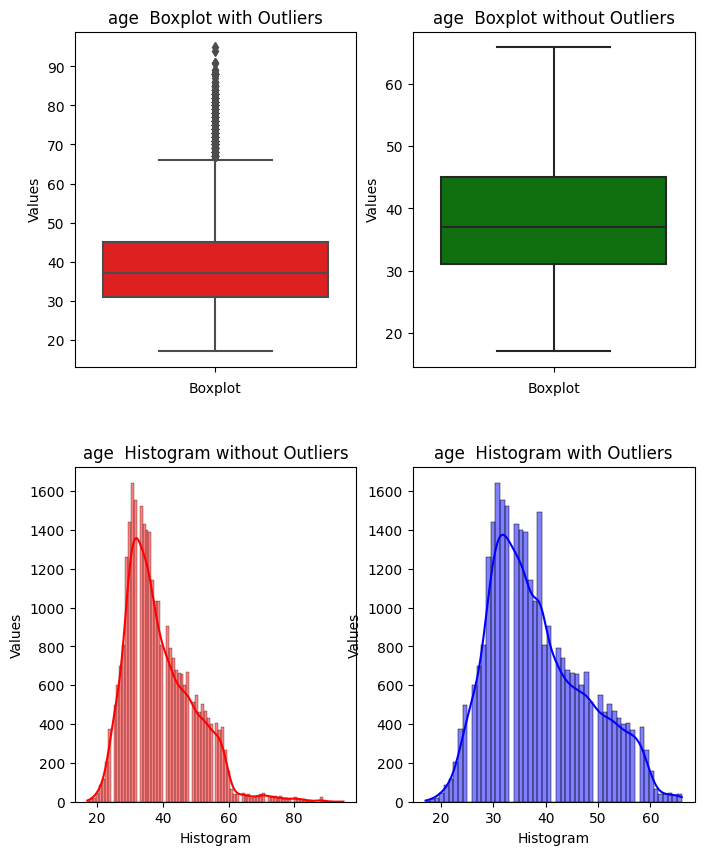

The outlier density is 0.015022303857255314
--------------------------------------------

--------------------------------------------


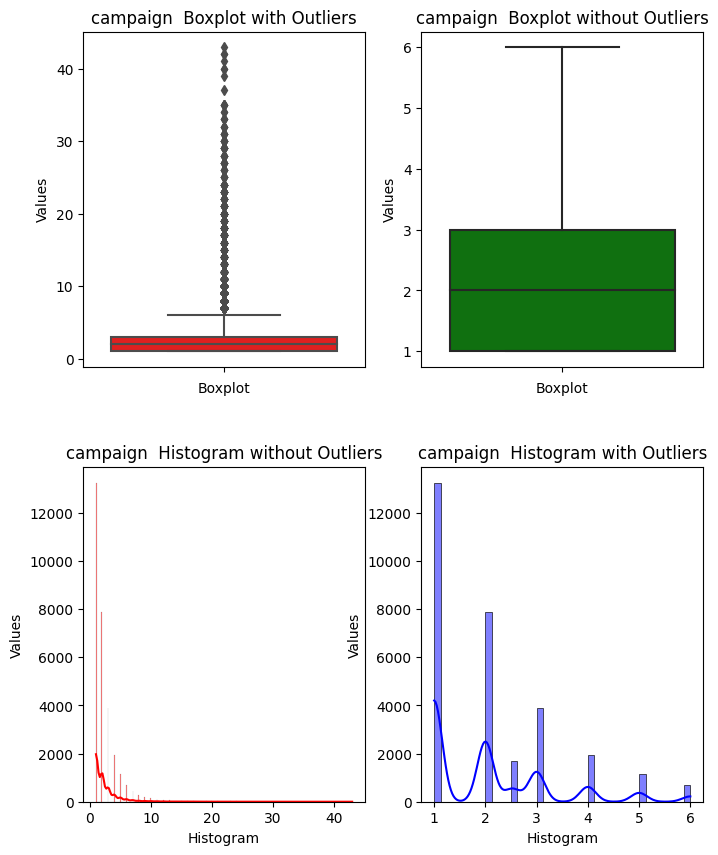

The outlier density is 0.05493964838625033
--------------------------------------------

--------------------------------------------


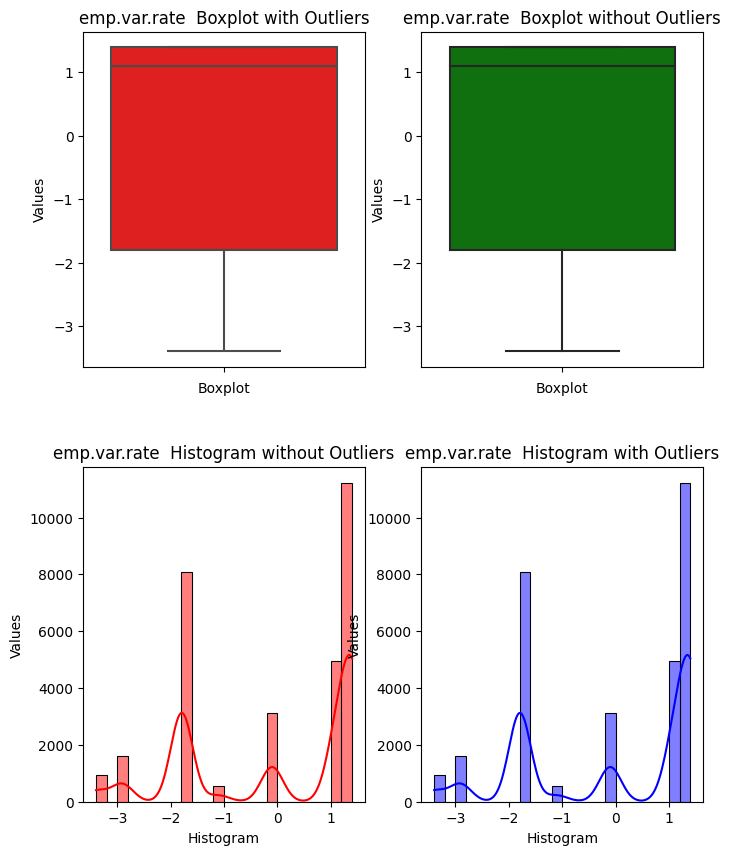

The outlier density is 0.0
--------------------------------------------

--------------------------------------------


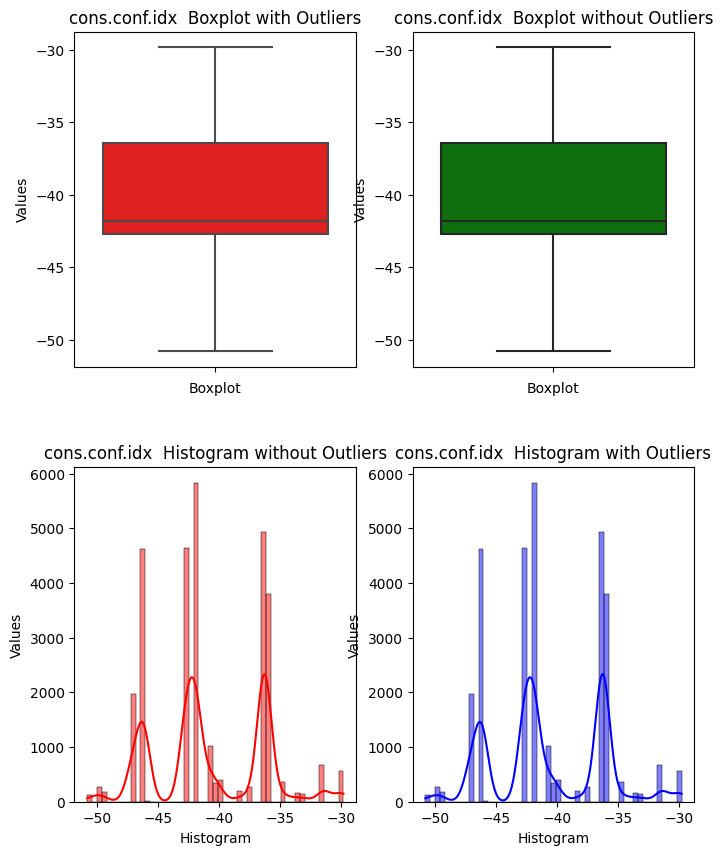

The outlier density is 0.012988716872212017
--------------------------------------------



In [47]:
# Outlier treatment for the columns
columns_to_be_treated = ["age", "campaign", "emp.var.rate", "cons.conf.idx"]

for column in columns_to_be_treated:
    remove_outlier(dataset=dataset, column=column, plot=True)